# Feature Engineering

In [200]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
import random

In [201]:
# Adjust settings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)
%matplotlib inline

# to make this notebook's output stable across runs
np.random.seed(42)

In [202]:
# Load preprocessed dataset

data_path = '../data/interim/'
df = pd.read_pickle(os.path.join(data_path, 'cleaned.pkl'))


In [203]:
# Create new feature for routing as dep arpt_arr arpt
df['routing'] = df['flt_dep_airpt'].astype(str) + '_' + df['flt_arr_airpt'].astype(str)

In [204]:
df.head()

,flt_leg,flt_dep_airpt,flt_arr_airpt,flt_offblock,flt_onblock,flt_ac_reg,flt_change_code,flt_dep_delay,flt_ac_type,flt_tt,flt_sched_tt,flt_crewg,flt_TLC_trans,flt_crewt_change,flt_sched_gt,flt_act_gt,flt_sched_dep,flt_sched_arr,gnd_sched_tat,arr_delay,routing
0,272005011,North Gregory,East Carmen,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0.0,0.0,Start,"[Jason Brown_nan_nan_nan_cp, Jacob Stein_nan_n...",[],235.0,268.0,2019-06-01 00:40:00,2019-06-01 04:30:00,NaN,-18.0,North Gregory_East Carmen
1,272009188,Port Bobby,East Carmen,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0.0,0.0,Start,"[Scott Baker_nan_nan_nan_cp, Ruth Hoffman_nan_...",[],130.0,189.0,2019-06-01 02:05:00,2019-06-01 04:00:00,NaN,-20.0,Port Bobby_East Carmen
2,271984537,Port Ryan,East Carmen,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0.0,0.0,Start,"[Cory Cooper_nan_nan_nan_ca, Morgan Foster_nan...",[],185.0,196.0,2019-06-01 02:20:00,2019-06-01 03:50:00,NaN,7.0,Port Ryan_East Carmen
3,272025831,Coleland,East Carmen,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0.0,0.0,Start,"[Anne Davis_nan_nan_nan_ca, Miss Amanda Harris...",[],145.0,175.0,2019-06-01 02:25:00,2019-06-01 04:00:00,NaN,-11.0,Coleland_East Carmen
4,272006092,East Melissaberg,East Carmen,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0.0,0.0,Start,"[Renee Fisher_nan_nan_nan_ca, Rebecca Castro_n...",[],35.0,21.0,2019-06-01 02:30:00,2019-06-01 04:15:00,NaN,28.0,East Melissaberg_East Carmen


In [205]:
# Save flight crew, cabin crew names and their size in new features and drop the original variable afterwards
cp_crew = []
ca_crew = []
cp_count = []
ca_count = []

for crew in df['flt_TLC_trans']:
    cp_help = []
    ca_help = []
    for member in crew:
        if 'cp' in member:
            cp_help.append(member.partition('_')[0])
        elif 'ca' in member:
            ca_help.append(member.partition('_')[0])
    cp_crew.append(sorted(cp_help))
    ca_crew.append(sorted(ca_help))
    cp_count.append(len(cp_help))
    ca_count.append(len(ca_help))

df['cp_crew'] = cp_crew
df['ca_crew'] = ca_crew
df['cp_count'] = cp_count
df['ca_count'] = ca_count

df = df.drop(columns='flt_TLC_trans')

In [206]:
df.head()

,flt_leg,flt_dep_airpt,flt_arr_airpt,flt_offblock,flt_onblock,flt_ac_reg,flt_change_code,flt_dep_delay,flt_ac_type,flt_tt,flt_sched_tt,flt_crewg,flt_crewt_change,flt_sched_gt,flt_act_gt,flt_sched_dep,flt_sched_arr,gnd_sched_tat,arr_delay,routing,cp_crew,ca_crew,cp_count,ca_count
0,272005011,North Gregory,East Carmen,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0.0,0.0,Start,[],235.0,268.0,2019-06-01 00:40:00,2019-06-01 04:30:00,NaN,-18.0,North Gregory_East Carmen,"[Cody Brown, Jason Brown]","[Brian Moore, Jacob Stein, Jessica Hendricks, ...",2,4
1,272009188,Port Bobby,East Carmen,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0.0,0.0,Start,[],130.0,189.0,2019-06-01 02:05:00,2019-06-01 04:00:00,NaN,-20.0,Port Bobby_East Carmen,"[David Moody, Scott Baker]","[Brian Maxwell, Daniel George, Ruth Hoffman]",2,3
2,271984537,Port Ryan,East Carmen,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0.0,0.0,Start,[],185.0,196.0,2019-06-01 02:20:00,2019-06-01 03:50:00,NaN,7.0,Port Ryan_East Carmen,"[Brian Lester, Morgan Foster]","[Cory Cooper, James Sandoval]",2,2
3,272025831,Coleland,East Carmen,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0.0,0.0,Start,[],145.0,175.0,2019-06-01 02:25:00,2019-06-01 04:00:00,NaN,-11.0,Coleland_East Carmen,"[Miss Amanda Harris MD, Russell Yang]","[Amy Dunn, Anne Davis, Brian Lee, Kimberly Pratt]",2,4
4,272006092,East Melissaberg,East Carmen,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0.0,0.0,Start,[],35.0,21.0,2019-06-01 02:30:00,2019-06-01 04:15:00,NaN,28.0,East Melissaberg_East Carmen,"[Rebecca Castro, Robert Yoder]","[Renee Fisher, Todd Young]",2,2


In [207]:
# Create two new features from flt_crew_change:
# 1. Indicator whether cabin, flight or both crews changed aircraft
# 2. Number of crew members who changed aircraft
def crew_change_cp_ca (row):
    if all(x in row['flt_crewt_change'] for x in ['ca', 'cp']):
        return 'both'
    if 'cp' in row['flt_crewt_change']:
        return 'flight_crew'
    elif 'ca' in row['flt_crewt_change']:
        return 'cabin_crew'
    else:
        return None

def crew_members (row):
    return len(row['flt_crewt_change'])

df['cc_cp_ca'] = df.apply(crew_change_cp_ca, axis=1)
df['cc_count'] = df.apply(crew_members, axis=1)

In [208]:
# Create new features for day of the week and hour of the day
df['day_of_week'] = df['flt_sched_dep'].dt.dayofweek
df['hour_of_day_dep'] = df['flt_sched_dep'].dt.hour
df['hour_of_day_arr'] = df['flt_sched_arr'].dt.hour

# Further data checks

In [209]:
# Check whether flt_crewt_change and flt_crewg match
pd.crosstab(df['flt_crewg'], df['cc_count'])

cc_count,0,1,2,3,4,5,6,7,8
flt_crewg,,,,,,,,,
A,5108,166,123,172,184,187,3,1,1
B,493,0,0,0,0,0,0,0,0
B2,0,0,0,55,60,295,15,0,0
C,0,321,184,100,97,43,1,0,0
Start,4283,0,0,0,0,0,0,0,0


There seems to be a mismatch between the variables flt_crewg and the number of crew members who changed the aircraft based on the definition of the variable flt_crewg according to the documentation:
Crew Group: assignment of what happens to the whole crew after a flight
-  Start : First flight of day
-  A : all crew members stay on the aircraft for the next flight
-  B, B2: all crew members switch aircraft for the next flight
-  C: at least one crew member switches aircraft for the next flight

For flt_crewg == A there should only be cc_count == 0 and for flt_crewg == B there should only be cc_count != 0. Therefore a further analysis is done on that.

In [210]:
# Identifying a specific aircraft wherer flt_crewg == A and cc_count != 0 to analyse the crew changes for a specific date
np.random.seed(42)
indexes = df[(df['flt_crewg'] == 'A') & (df['cc_count'] != 0)].index
sample = random.sample(list(indexes), 3)
print(sample)
df[(df['flt_crewg'] == 'A') & (df['cc_count'] != 0)].loc[sample]

[11680, 5009, 2654]


,flt_leg,flt_dep_airpt,flt_arr_airpt,flt_offblock,flt_onblock,flt_ac_reg,flt_change_code,flt_dep_delay,flt_ac_type,flt_tt,flt_sched_tt,flt_crewg,flt_crewt_change,flt_sched_gt,flt_act_gt,flt_sched_dep,flt_sched_arr,gnd_sched_tat,arr_delay,routing,cp_crew,ca_crew,cp_count,ca_count,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr
11680,272017201,East Carmen,Haynesside,2019-06-30 11:19:00,2019-06-30 12:33:00,ECLGBX,other problem,14.0,DH4,45.0,50.0,A,"[cp, cp, ca]",55.0,34.0,2019-06-30 11:05:00,2019-06-30 12:10:00,50.0,23.0,East Carmen_Haynesside,"[David Smith, Mark Young]","[Gary Buchanan, Thomas Lowery MD]",2,2,both,3,6,11,12
5009,271997836,East Carmen,Joneshaven,2019-06-13 16:41:00,2019-06-13 17:55:00,ECLBPX,technical problem,66.0,320,49.0,55.0,A,"[ca, ca, ca, cp, cp]",50.0,94.0,2019-06-13 15:35:00,2019-06-13 17:00:00,55.0,55.0,East Carmen_Joneshaven,"[Felicia Simmons, Joshua Ellis]","[Ellen Barnes, Greg Jones, Nathaniel Lyons, Pe...",2,4,both,5,3,15,17
2654,271965033,East Carmen,Dawsonhaven,2019-06-07 16:08:00,2019-06-07 17:14:00,ECLWAX,rotational problem,43.0,E95,49.0,55.0,A,"[cp, cp]",45.0,50.0,2019-06-07 15:25:00,2019-06-07 16:40:00,55.0,34.0,East Carmen_Dawsonhaven,"[Cassandra Nguyen, Thomas Conway]","[Brandon Johnson, Brian Hall, Gregory White]",2,3,flight_crew,2,4,15,16


In [211]:
#NEEDS TO BE REDONE - NO RANDOM SEED FIRST TIME

# Now looking at the crew change history of the first registration for the specific day
df[(df['flt_ac_reg'] == 'ECLXBX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-02')].iloc[:,[11, 12, 19, 20, 21, 22, 23, 24]]

,flt_crewg,flt_crewt_change,routing,cp_crew,ca_crew,cp_count,ca_count,cc_cp_ca
400,Start,[],East Carmen_Yoderburgh,"[Jacob Davis, Larry Foster]","[Cody Powell, Derek Hendricks, Hunter Harper, ...",2,4,None
432,A,[],Yoderburgh_East Carmen,"[Jacob Davis, Larry Foster]","[Cody Powell, Derek Hendricks, Hunter Harper, ...",2,4,None
489,A,"[ca, ca, cp, cp, ca]",East Carmen_Lake Lawrencechester,"[Jacob Davis, Larry Foster]","[Cody Powell, Derek Hendricks, Hunter Harper, ...",2,4,both
543,A,[ca],Lake Lawrencechester_East Carmen,"[Mckenzie Reed, Shawn Schultz]","[Candice Smith, Jeremy Patel, Jimmy Lewis, Nat...",2,4,cabin_crew
599,A,"[ca, ca, ca, cp, cp]",East Carmen_Lake Lawrencechester,"[Mckenzie Reed, Shawn Schultz]","[Candice Smith, Jeremy Patel, Nathaniel Pineda...",2,4,both
662,A,[],Lake Lawrencechester_East Carmen,"[Mckenzie Reed, Shawn Schultz]","[Candice Smith, Jeremy Patel, Nathaniel Pineda...",2,4,None


Based on the hypothesis that the names of the crews are being recorded correctly as this might not only be relevant for payroll accounting but also from regulative perspective the flt_crewg and flt_crewt_change values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
400 | A | [] |
432 | C | [ca] |
489 | B | [cp, cp, ca, ca, ca, ca] |
543 | C | [ca] |
599 | A | [] |
1137 | NaN | NaN |

In [212]:
#NEEDS TO BE REDONE - NO RANDOM SEED FIRST TIME

# Let's have a detailed look at the second example
df[(df['flt_ac_reg'] == 'ECLGBX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-28')].iloc[:,[11, 12, 19, 20, 21, 22, 23, 24]]

,flt_crewg,flt_crewt_change,routing,cp_crew,ca_crew,cp_count,ca_count,cc_cp_ca
10705,Start,[],Lake David_East Carmen,"[Nicholas Rocha, Olivia Jacobs]","[Mark Gross, Monique Soto]",2,2,None
10738,C,[cp],East Carmen_Keithberg,"[Molly Woods, Stacy Heath]","[Emily Oconnell, John Martinez]",2,2,flight_crew
10782,A,[],Keithberg_East Carmen,"[Molly Woods, Stacy Heath]","[Emily Oconnell, John Martinez]",2,2,None
10810,C,[ca],East Carmen_Port Courtneytown,"[Abigail Garcia, Stacy Heath]","[Jacqueline Wright, John Martinez]",2,2,cabin_crew
10862,Start,[],Port Courtneytown_East Carmen,"[Derek Sweeney, Katie Gallegos]","[Brian Lopez, Teresa Garner]",2,2,None
10899,A,"[ca, ca, cp]",East Carmen_Port Ryan,"[Katie Gallegos, Patrick Cardenas]","[Brian Lopez, Teresa Garner]",2,2,both
10932,A,[],Port Ryan_East Carmen,"[Katie Gallegos, Patrick Cardenas]","[Brian Lopez, Teresa Garner]",2,2,None
10988,A,[],East Carmen_Port Courtneytown,"[Katie Gallegos, Patrick Cardenas]","[Brian Lopez, Teresa Garner]",2,2,None
11031,Start,[],Port Courtneytown_East Carmen,"[Destiny Sanchez, Melissa Williams]","[Cynthia Johnson, William Martinez]",2,2,None
11061,A,[],East Carmen_North Anna,"[Destiny Sanchez, Melissa Williams]","[Cynthia Johnson, William Martinez]",2,2,None


For the second example the values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
10705 | B | [cp, cp, ca, ca] |
10738 | A | [] |
10782 | C | [cp, cp, ca] |
10810 | B | [cp, cp, ca, ca] |
10862 | C | [cp, cp] |
10899 | A | [] |
10932 | A | [] |
10988 | B | [cp, cp, ca, ca] |
11031 | A | [] |
11061 | A | [] |
11106 | NaN | NaN |

In [213]:
#NEEDS TO BE REDONE - NO RANDOM SEED FIRST TIME

# Let's have a detailed look at the third example
df[(df['flt_ac_reg'] == 'ECLGRX') & (df['flt_sched_dep'].dt.strftime('%Y-%m-%d') == '2019-06-05')].iloc[:,[11, 12, 19, 20, 21, 22, 23, 24]]

,flt_crewg,flt_crewt_change,routing,cp_crew,ca_crew,cp_count,ca_count,cc_cp_ca
1593,B2,"[cp, ca, ca]",East Carmen_West Ana,"[Elizabeth Avila, Luis Patel]","[James Harris, Matthew Wallace]",2,2,both
1655,A,[],West Ana_East Carmen,"[Elizabeth Avila, Luis Patel]","[James Harris, Matthew Wallace]",2,2,None
1739,Start,[],East Carmen_Haynesside,"[Kyle Chapman, Samantha Ball]","[Eduardo Ho, Sergio Ponce]",2,2,None
1781,A,[],Haynesside_East Carmen,"[Kyle Chapman, Samantha Ball]","[Eduardo Ho, Sergio Ponce]",2,2,None
1824,A,"[cp, cp, ca]",East Carmen_Keithberg,"[Kyle Chapman, Samantha Ball]","[Eduardo Ho, Todd Young]",2,2,both
1874,A,[],Keithberg_East Carmen,"[Kyle Chapman, Samantha Ball]","[Eduardo Ho, Todd Young]",2,2,None
1921,A,[],East Carmen_North Christopherburgh,"[Kyle Chapman, Samantha Ball]","[Eduardo Ho, Todd Young]",2,2,None


For the second example the values should be the following:
|   | flt_crewg | flt_crewt_change |
| --- | --- | --- |
1593 | A | [] |
1655 | B | [cp, cp, ca, ca] |
1739 | A | [] |
1781 | C | [ca] |
1824 | A | [] |
1874 | A | [] |
1921 | NaN | Nan |

Within this sample only a few entries in flt_crewg and flt_crewt_change match with the data crew data over the rotation of a single registration over a day. Furthermore, there is a general error in the variable flt_crewg as it always shows Start for the first leg of the day, however the variable shall state "what happens to the whole crew after a flight".
Due to this new features to capture crew changes will be established based on the columns cp_crew and ca_crew for the rotation of a specific aircraft on any given day.

In [214]:
# Creating new features to track crew changes from the flight before: cc_type {0: Start - First flight of the day, 1: No crew change;
# 2: At least one member but not all of the crew changed; 3: Whole crew changed}; cc_roles [list of elements either ca or cp with an
# entry for every crew member that changed aircraft]

# Furthermore routing check could be included and update of cc_count and cc_ca_cp could be incorporated

def crew_changes (registrations):
    # Create an empty df that will be appended in every step and finally returned by the function
    cc = pd.DataFrame(columns=['cc_types', 'cc_roles'])
    # Loop through the aircrafts and sort their flights by sched_dep
    for aircraft in registrations:
        indexes = df[df['flt_ac_reg'] == aircraft].sort_values(by='flt_sched_dep').index
        date = '2019-01-01'
        # Loop through the indexes of a specific aircraft
        for idx in indexes:
            cc_roles = []
            # If index has new date and therefore is first flight of the day
            if date not in str(df['flt_sched_dep'].loc[idx]):
                date = str(df['flt_sched_dep'].loc[idx]).partition(' ')[0]
                cp = df['cp_crew'].loc[idx]
                ca = df['ca_crew'].loc[idx]
                help = pd.DataFrame([[0, []]], columns=['cc_types', 'cc_roles'], index=[idx])
            else:
                # Check differences between flight and cabin crew from previous flight
                dif_cp = list(set(cp) - set(df['cp_crew'].loc[idx]))
                dif_ca = list(set(ca) - set(df['ca_crew'].loc[idx]))
                # If no crew members changed
                if (len(dif_cp) == 0) and (len(dif_ca) == 0):
                    help = pd.DataFrame([[1, []]], columns=['cc_types', 'cc_roles'], index=[idx])
                # If all crew members changed
                elif (len(dif_cp) >= len(cp)) and (len(dif_ca) >= len(ca)):
                    for item in dif_cp:
                        cc_roles.append('cp')
                    for item in dif_ca:
                        cc_roles.append('ca')
                    help = pd.DataFrame([[3, cc_roles]], columns=['cc_types', 'cc_roles'], index=[idx])
                else:
                    for item in dif_cp:
                        cc_roles.append('cp')
                    for item in dif_ca:
                        cc_roles.append('ca')
                    help = pd.DataFrame([[2, cc_roles]], columns=['cc_types', 'cc_roles'], index=[idx])
                cp = df['cp_crew'].loc[idx]
                ca = df['ca_crew'].loc[idx]
            cc = cc.append(help)
    return cc

# Create a list of all registrations in the dataset
registrations = df['flt_ac_reg'].unique()

df = pd.merge(df, crew_changes(registrations), left_index=True, right_index=True)
# Finally drop old columns
df = df.drop(columns=['flt_crewg', 'flt_crewt_change'])

# Visual data analysis

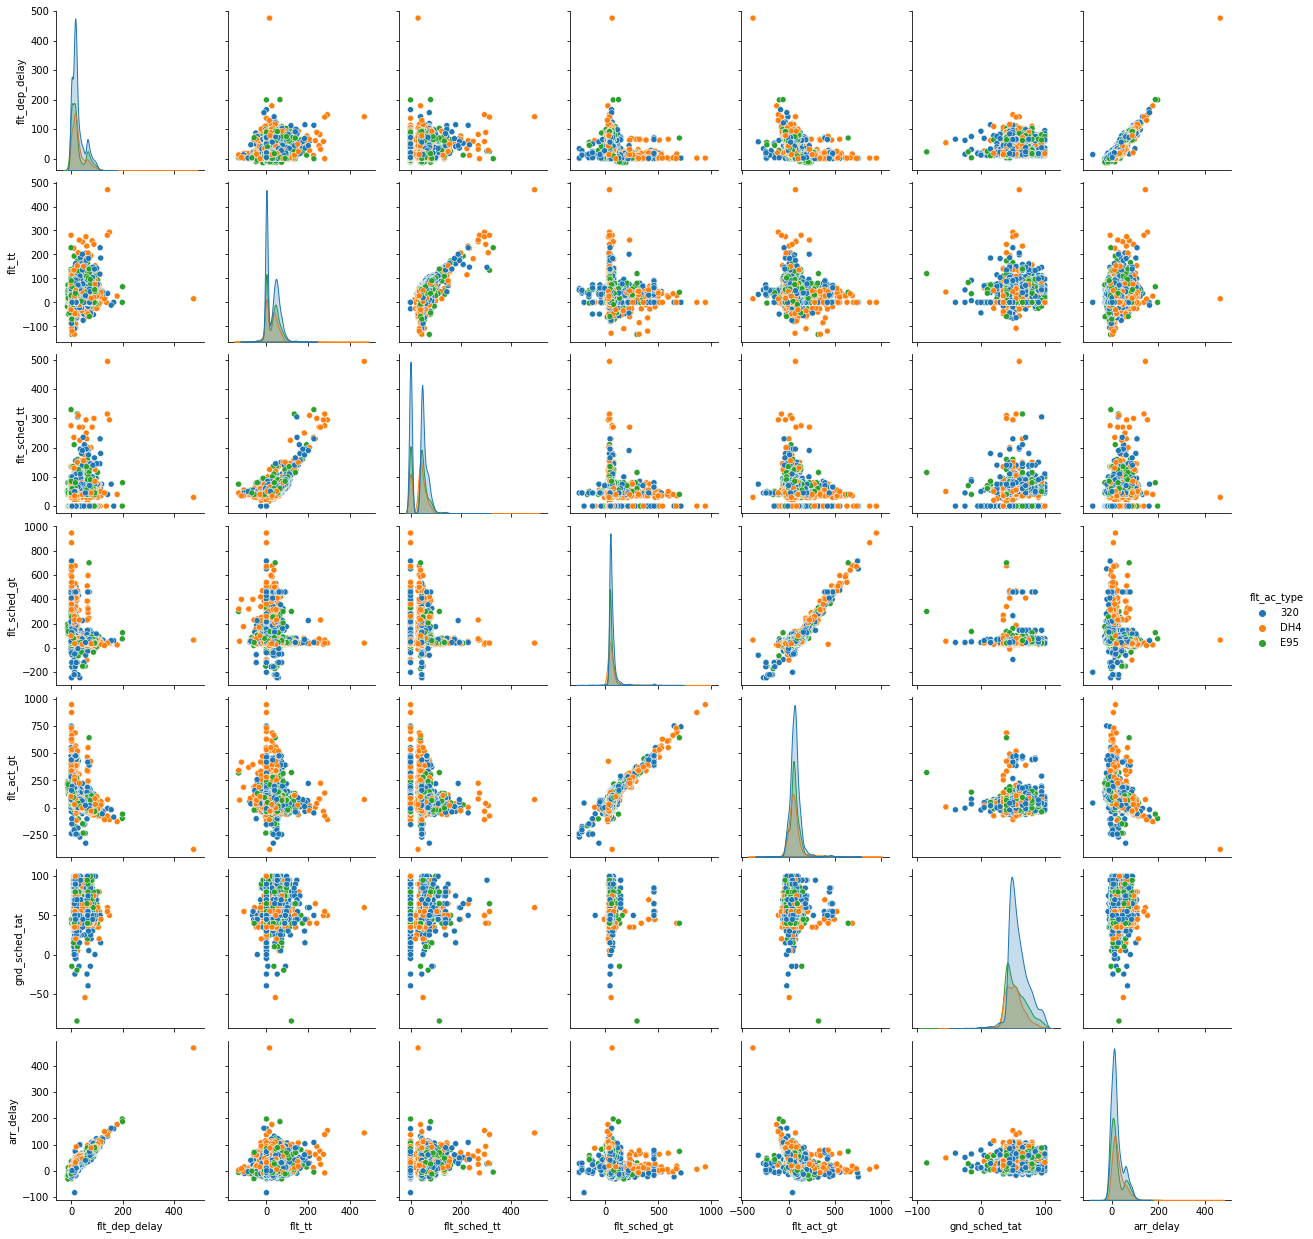

In [215]:
# Pairplot of all numerical values including dependent variable
data = df[['flt_dep_delay', 'flt_tt', 'flt_sched_tt', 'flt_sched_gt', 'flt_act_gt', 'gnd_sched_tat', 'arr_delay']]
sns.pairplot(df, hue='flt_ac_type', vars=data, diag_kind='kde')

<AxesSubplot:>

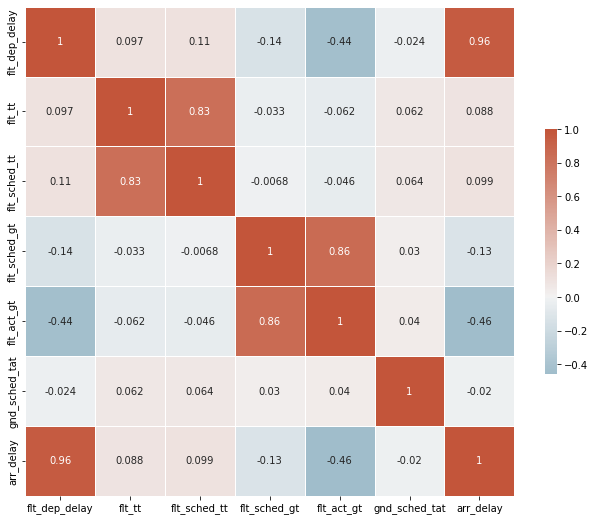

In [216]:
corr = data.corr()
f, ax = plt.subplots(figsize=(11, 9))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=1, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [217]:
df.head()

,flt_leg,flt_dep_airpt,flt_arr_airpt,flt_offblock,flt_onblock,flt_ac_reg,flt_change_code,flt_dep_delay,flt_ac_type,flt_tt,flt_sched_tt,flt_sched_gt,flt_act_gt,flt_sched_dep,flt_sched_arr,gnd_sched_tat,arr_delay,routing,cp_crew,ca_crew,cp_count,ca_count,cc_cp_ca,cc_count,day_of_week,hour_of_day_dep,hour_of_day_arr,cc_types,cc_roles
0,272005011,North Gregory,East Carmen,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0.0,0.0,235.0,268.0,2019-06-01 00:40:00,2019-06-01 04:30:00,NaN,-18.0,North Gregory_East Carmen,"[Cody Brown, Jason Brown]","[Brian Moore, Jacob Stein, Jessica Hendricks, ...",2,4,None,0,5,0,4,0,[]
1,272009188,Port Bobby,East Carmen,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0.0,0.0,130.0,189.0,2019-06-01 02:05:00,2019-06-01 04:00:00,NaN,-20.0,Port Bobby_East Carmen,"[David Moody, Scott Baker]","[Brian Maxwell, Daniel George, Ruth Hoffman]",2,3,None,0,5,2,4,0,[]
2,271984537,Port Ryan,East Carmen,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0.0,0.0,185.0,196.0,2019-06-01 02:20:00,2019-06-01 03:50:00,NaN,7.0,Port Ryan_East Carmen,"[Brian Lester, Morgan Foster]","[Cory Cooper, James Sandoval]",2,2,None,0,5,2,3,0,[]
3,272025831,Coleland,East Carmen,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0.0,0.0,145.0,175.0,2019-06-01 02:25:00,2019-06-01 04:00:00,NaN,-11.0,Coleland_East Carmen,"[Miss Amanda Harris MD, Russell Yang]","[Amy Dunn, Anne Davis, Brian Lee, Kimberly Pratt]",2,4,None,0,5,2,4,0,[]
4,272006092,East Melissaberg,East Carmen,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0.0,0.0,35.0,21.0,2019-06-01 02:30:00,2019-06-01 04:15:00,NaN,28.0,East Melissaberg_East Carmen,"[Rebecca Castro, Robert Yoder]","[Renee Fisher, Todd Young]",2,2,None,0,5,2,4,0,[]


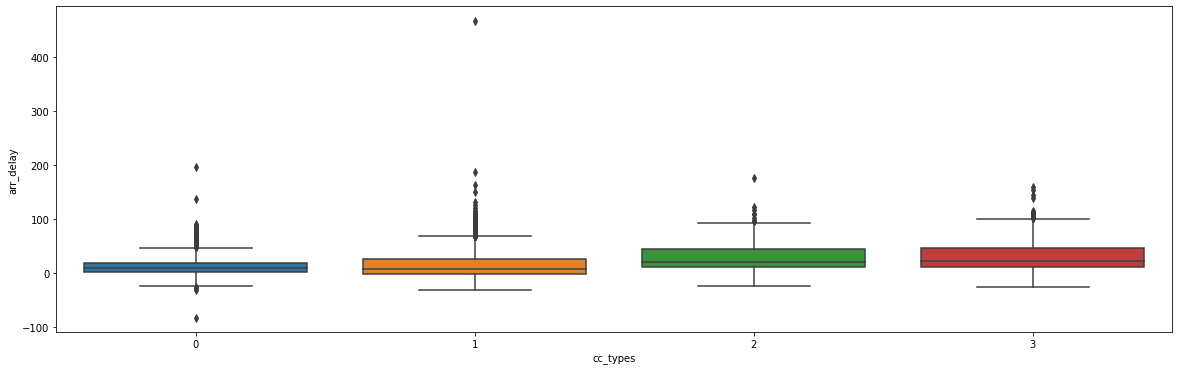

In [218]:
f, ax = plt.subplots(figsize=(20, 6))
ax = sns.boxplot(x=df['cc_types'], y=df['arr_delay'])
#len(df['arr_delay'])
#x=df['flt_dep_airpt'],

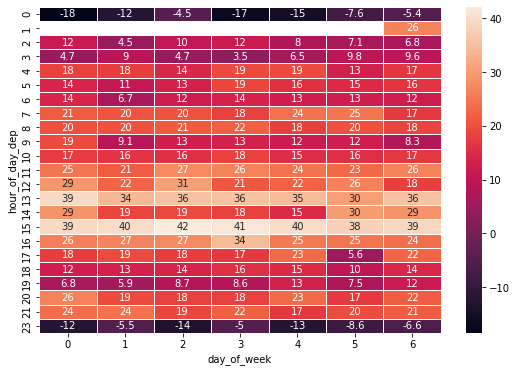

In [219]:
# Heatmap for day of week, hour of day and arr_delay
data = df.pivot_table(index='hour_of_day_dep', columns='day_of_week', values='arr_delay', aggfunc=np.mean)
f, ax = plt.subplots(figsize=(9, 6))
ax = sns.heatmap(data, annot=True,linewidths=.5, ax=ax)

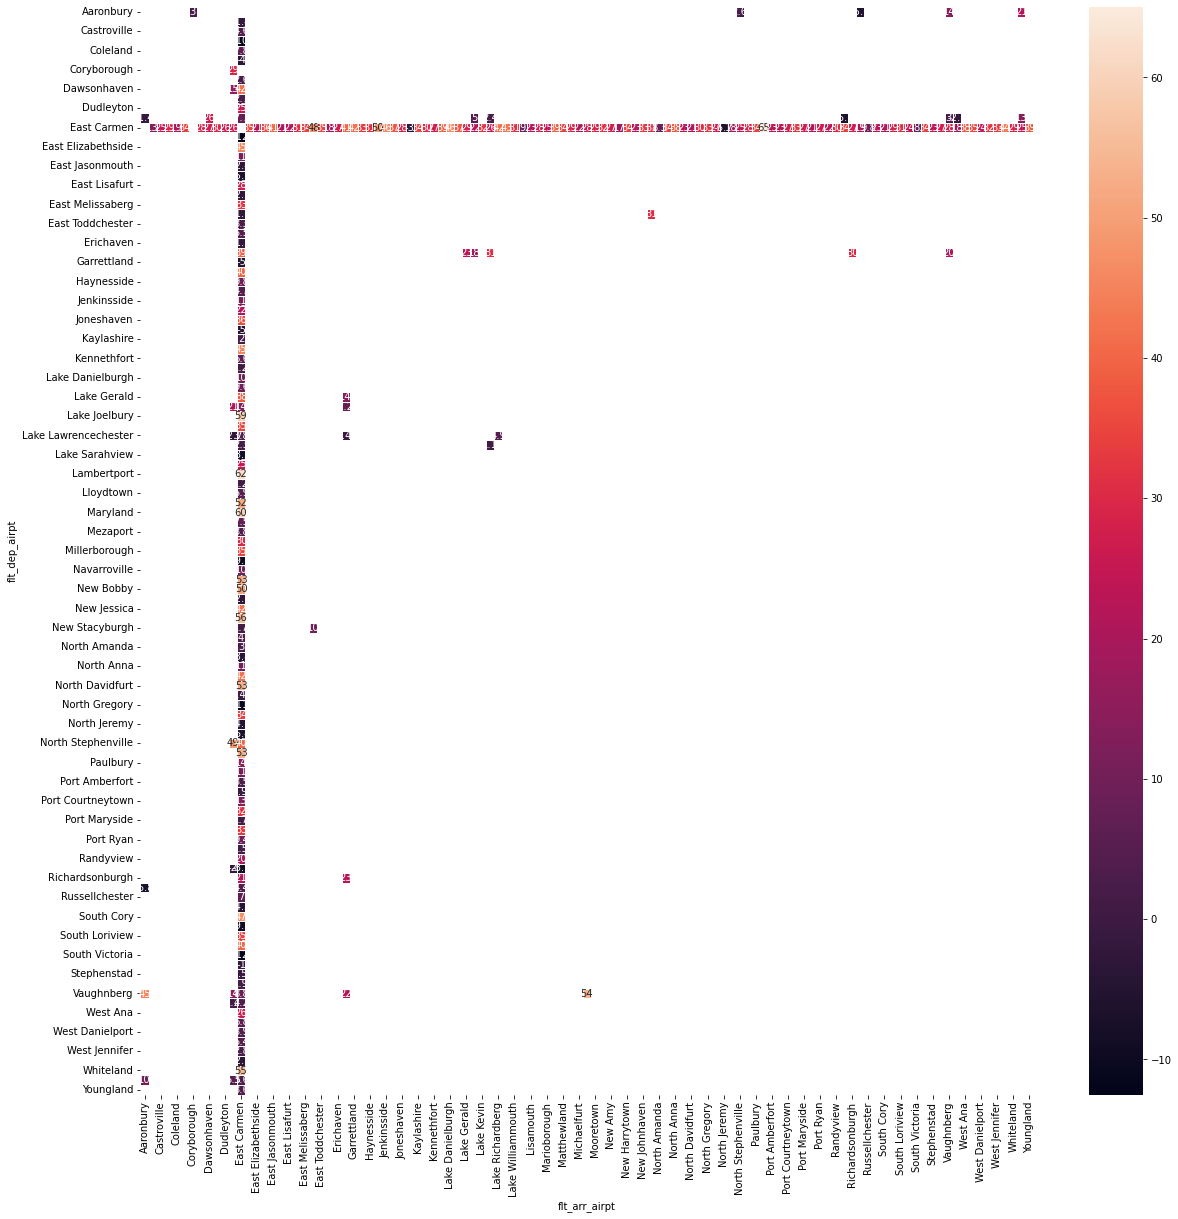

In [223]:
# Heatmap for day of week, hour of day and arr_delay
data = df.pivot_table(index='flt_dep_airpt', columns='flt_arr_airpt', values='arr_delay', aggfunc=np.mean)
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(data, annot=True,linewidths=.5, ax=ax)

<AxesSubplot:xlabel='flt_sched_dep', ylabel='arr_delay'>

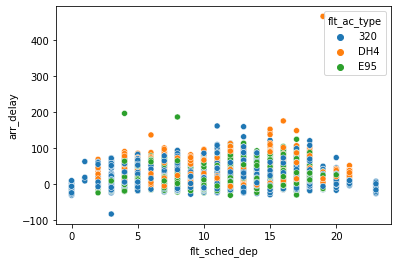

In [220]:
# Plot Scatterplot of arr_delay vs time on date
sns.scatterplot(x=df['flt_sched_dep'].dt.hour, y=df['arr_delay'], hue=df['flt_ac_type'])

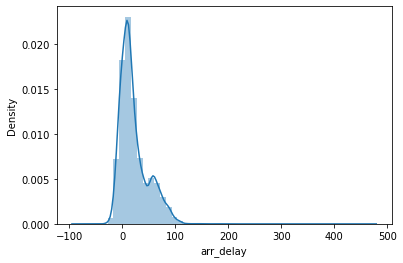

In [221]:
# Plot histogram of dependent variable including pdf
sns.distplot(df['arr_delay'], kde=True);